## A Curious Learning Task

Suppose we want to fit the following dataset.

In [7]:
using Plots
using LinearAlgebra
using Statistics
using Interact

gr()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4551697295503120380\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-712494046777998630\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4551697295503120380\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.GRBackend()

In [2]:
function gen_data(n::Int64)
    xs = rand(n);
    ys = cos.(2*xs .+ 20*xs.^2) .+ 0.1 * randn(n);
    return (xs, ys);
end

n = 256;
(xs, ys) = gen_data(n);
(xs_test, ys_test) = gen_data(n);

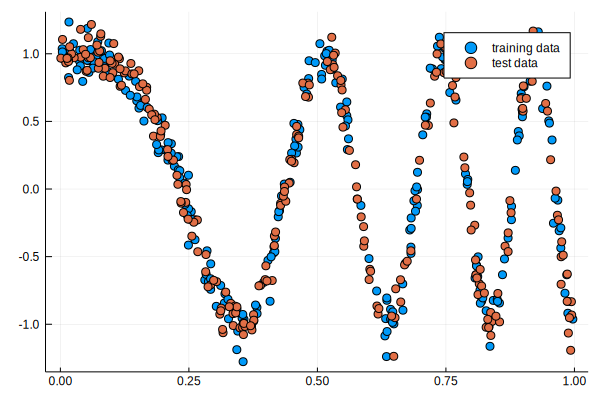

In [3]:
scatter(xs, ys; label="training data");
scatter!(xs_test, ys_test; label="test data")

### How will a linear model perform on this task?

Let's look at linear regression.

$$\min_{a,b} \sum_{i=1}^n (ax_i + b - y_i)^2.$$

In [4]:
Xs_homogeneous = vcat(xs', ones(1, n));

(a,b) = inv(Xs_homogeneous * Xs_homogeneous') * Xs_homogeneous * ys;

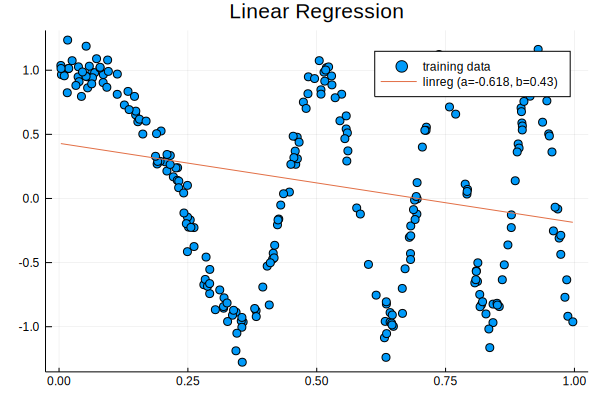

In [5]:
scatter(xs, ys; label="training data", title="Linear Regression");
plot!(sort(xs), a * sort(xs) .+ b; label="linreg (a=$(round(a;digits=3)), b=$(round(b;digits=3)))")

In [6]:
# what's the average mean-squared error?

training_loss = mean((a * xs[i] + b - ys[i])^2 for i = 1:n);
test_loss = mean((a * xs_test[i] + b - ys_test[i])^2 for i = 1:n);

println("training loss = $training_loss")
println("test loss = $test_loss")

training loss = 0.48579381255099896
test loss = 0.5120914346731615


## Can we do better?

One way to do this is to use a more sophisticated model. One such model is the piecewise linear model.

In [90]:
function piecewise_linear_eval(x::Float64, zs::Array{Tuple{Float64,Float64},1})
    for i = 1:length(zs)
        if ((x >= zs[i][1]) && (x <= zs[i+1][1]))
            (x0, y0) = zs[i];
            (x1, y1) = zs[i+1];
            return ((x - x0)/(x1 - x0)) * (y1 - y0) + y0;
        end
    end
    return 0.0;
end

function piecewise_linear_widget(xs::Array{Float64,1}, ys::Array{Float64,1})
    xinits = [0.36, 0.5, 0.62, 0.74, 0.82, 0.95];
    yinits = sort(rand(6); rev=true);
    x1 = slider(0.0:0.01:1.0, label="x1", value=xinits[1]);
    y1 = slider(-1.2:0.01:1.2, label="y1", value=yinits[1]);
    x2 = slider(0.0:0.01:1.0, label="x2", value=xinits[2]);
    y2 = slider(-1.2:0.01:1.2, label="y2", value=yinits[2]);
    x3 = slider(0.0:0.01:1.0, label="x3", value=xinits[3]);
    y3 = slider(-1.2:0.01:1.2, label="y3", value=yinits[3]);
    x4 = slider(0.0:0.01:1.0, label="x4", value=xinits[4]);
    y4 = slider(-1.2:0.01:1.2, label="y4", value=yinits[4]);
    x5 = slider(0.0:0.01:1.0, label="x5", value=xinits[5]);
    y5 = slider(-1.2:0.01:1.2, label="y5", value=yinits[5]);
    x6 = slider(0.0:0.01:1.0, label="x6", value=xinits[6]);
    y6 = slider(-1.2:0.01:1.2, label="y6", value=yinits[6]);
    keypoints = Interact.@map sort([(0.0,1.0), (&x1,&y1), (&x2,&y2), (&x3,&y3), (&x4,&y4), (&x5,&y5), (&x6,&y6), (1.0,-1.0)]);
    err = Interact.@map mean((piecewise_linear_eval(xs[i], &keypoints) - ys[i])^2 for i = 1:n);
    plt = Interact.@map begin
        scatter(xs, ys; label="training data", title="Piecewise Linear Model (err=$(round(&err; digits=4)))", xlim=(0.0,1.0), ylim=(-1.3,1.3), legend=:bottomleft);
        plot!([z[1] for z in &keypoints], [z[2] for z in &keypoints]; label="piecewise linear", linewidth = 2, markershape = :square, markersize=5)
    end
    wdg = Widget([
                "x1" => x1, "y1" => y1,
                "x2" => x2, "y2" => y2,
                "x3" => x3, "y3" => y3,
                "x4" => x4, "y4" => y4,
                "x5" => x5, "y5" => y5,
                "x6" => x6, "y6" => y6], output = plt)
    @layout! wdg hbox(plt, vbox(hbox(:x1, :y1), hbox(:x2, :y2), hbox(:x3, :y3), hbox(:x4, :y4), hbox(:x5, :y5), hbox(:x6, :y6))) ## custom layout: by default things are stacked vertically
end

piecewise_linear_widget (generic function with 1 method)

In [91]:
piecewise_linear_widget(xs, ys)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{Scope}(Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}(:className => "webio-observable",:setInnerHtml => "<?xml version=\"1.0\" encoding=\"utf-8\"?>\n<svg xmlns=\"http://www.w3.org/2000/svg\" xmlns:xlink=\"http://www.w3.org/1999/xlink\" width=\"600\" height=\"400\" viewBox=\"0 0 2400 1600\">\n<defs>\n  <clipPath id=\"clip7000\">\n    <rect x=\"0\" y=\"0\" width=\"2400\" height=\"1600\"/>\n  </clipPath>\n</defs>\n<path clip-path=\"url(#clip7000)\" d=\"\nM0 1600 L2400 1600 L2400 0 L0 0  Z\n  \" fill=\"#ffffff\" fill-rule=\"evenodd\" fill-opacity=\"1\"/>\n<defs>\n  <clipPath id=\"clip7001\">\n    <rect x=\"480\" y=\"0\" width=\"1681\" height=\"1600\"/>\n  </clipPath>\n</defs>\n<path clip-path=\"url(#clip7000)\" d=\"\nM182.008 1487.47 L2352.76 1487.47 L2352.76 121.675 L182.008 121.675  Z\n  \" fill=\"#ffffff\" fill-rule=\"evenodd\" fill-opacity=\"1\"/>\n<defs>\n  <clipPath id=\"clip7002\">\n    <rect x=\"182\" y=\"121\" width=\"2172\" height=\"1367\"/>\n  </clipPath>\n</defs>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,1487.47 182.008,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  616.158,1487.47 616.158,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  1050.31,1487.47 1050.31,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  1484.46,1487.47 1484.46,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  1918.61,1487.47 1918.61,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  2352.76,1487.47 2352.76,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,1329.88 2352.76,1329.88 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,1067.23 2352.76,1067.23 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,804.575 2352.76,804.575 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,541.921 2352.76,541.921 \n  \"/>\n<polyline clip-path=\"url(#clip7002)\" style=\"stroke:#000000; stroke-width:2; stroke-opacity:0.1; fill:none\" points=\"\n  182.008,279.267 2352.76,279.267 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  182.008,1487.47 2352.76,1487.47 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  182.008,1487.47 182.008,121.675 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  182.008,1487.47 182.008,1471.09 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  616.158,1487.47 616.158,1471.09 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  1050.31,1487.47 1050.31,1471.09 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  1484.46,1487.47 1484.46,1471.09 \n  \"/>\n<polyline clip-path=\"url(#clip7000)\" style=\"stroke:#000000; stroke-width:4; stroke-opacity:1; fill:none\" points=\"\n  1918.61,1

## This error is MUCH lower than what we got from the linear regression model!

But how can we learn this?

**Problem: the way we have parameterized this model is not continuous!**

To solve this problem, note that we can always represent a piecewise linear function as a sum of shifted and scaled ReLU functions. The ReLU function (**RE**ctified **L**inear **U**nit) is defined as

$$\operatorname{ReLU}(x) = \begin{cases}x & \text{if } x \ge 0 \\ 0 & \text{if } x \le 0\end{cases} = \max(x, 0).$$

We can visualize this as follows.

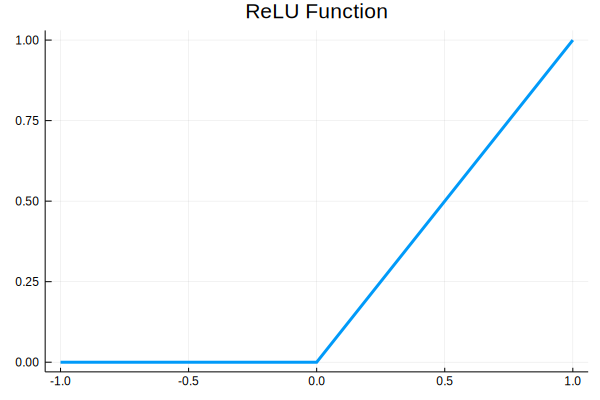

In [99]:
function ReLU(x::Float64)
    return max(x, 0);
end

us = collect(-1.0:0.01:1.0);
plot(us, ReLU.(us); linewidth=3, label="", title="ReLU Function")

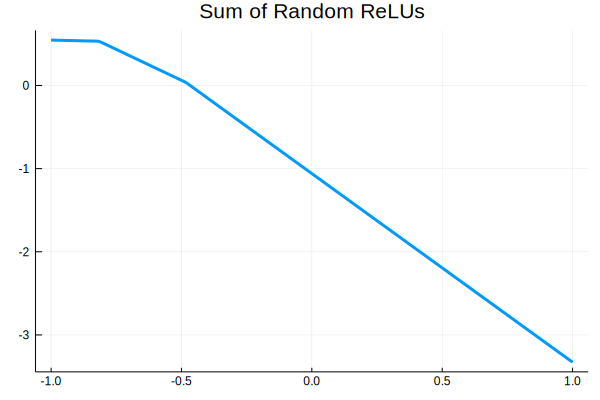

In [124]:
# to illustrate, here's a sum of some randomly shifted and scaled relus

us = collect(-1.0:0.01:1.0);
plot(us, sum(rand([-1.0,1.0]) * ReLU.(randn() * us .+ randn()) for i = 1:5); linewidth=3, label="", title="Sum of Random ReLUs")

We can try to parameterize our model as the sum of ReLU functions as follows.

$$h_{a,b,w}(x) = w_1 \cdot \operatorname{ReLU}(a_1 \cdot x + b_1) + w_2 \cdot \operatorname{ReLU}(a_2 \cdot x + b_2) + \cdots = \sum_{i=1}^d w_i \cdot \operatorname{ReLU}(a_i \cdot x + b_i).$$

This is guaranteed to be continuous in the parameters $a, b, w \in \mathbb{R}^d$. (Why?)

We can train this using SGD. To compute the gradient with respect to a loss function, observe that

$$\frac{\partial}{\partial w_i} \frac{1}{2} \left( h_{a,b,w}(x) - y \right)^2 = \left( h_{a,b,w}(x) - y \right) \cdot \operatorname{ReLU}(a_i \cdot x + b_i)$$

$$\frac{\partial}{\partial a_i} \frac{1}{2} \left( h_{a,b,w}(x) - y \right)^2 = \left( h_{a,b,w}(x) - y \right) \cdot w_i \cdot \operatorname{ReLU}'(a_i \cdot x + b_i) \cdot x$$

$$\frac{\partial}{\partial b_i} \frac{1}{2} \left( h_{a,b,w}(x) - y \right)^2 = \left( h_{a,b,w}(x) - y \right) \cdot w_i \cdot \operatorname{ReLU}'(a_i \cdot x + b_i)$$

In [516]:
function dReLU(x::Float64)
    return (x > 0.0) ? 1.0 : 0.0;
end

function heval(x::Float64, a::Array{Float64,1}, b::Array{Float64,1}, w::Array{Float64,1})
    d = length(a);
    @assert(length(b) == d);
    @assert(length(w) == d);
    
    return sum(w .* ReLU.(a .* x .+ b));
end

function grad(x::Float64, y::Float64, a::Array{Float64,1}, b::Array{Float64,1}, w::Array{Float64,1})
    d = length(a);
    @assert(length(b) == d);
    @assert(length(w) == d);
    
    axb = a .* x .+ b;
    dh = sum(w .* ReLU.(axb)) - y;
    
    dw = dh .* ReLU.(axb);
    da = dh .* w .* dReLU.(axb) .* x;
    db = dh .* w .* dReLU.(axb);
    
    return [da,db,dw];
end

grad (generic function with 1 method)

In [615]:
d = 1024;
a = rand([1.0,-1.0],d);
b = 2 * rand(d) .- 1;
w = randn(d);

alpha = 0.0001;

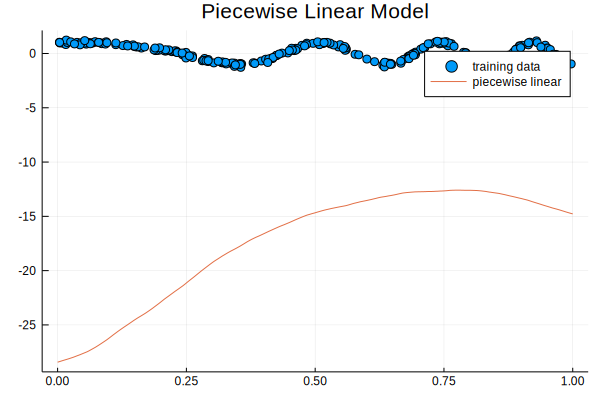

In [616]:
# what does the model look like when we initialize?

us = collect(0.0:0.001:1.0);
scatter(xs, ys; label="training data", title="Piecewise Linear Model");
plot!(us, [heval(u,a,b,w) for u in us]; label="piecewise linear")

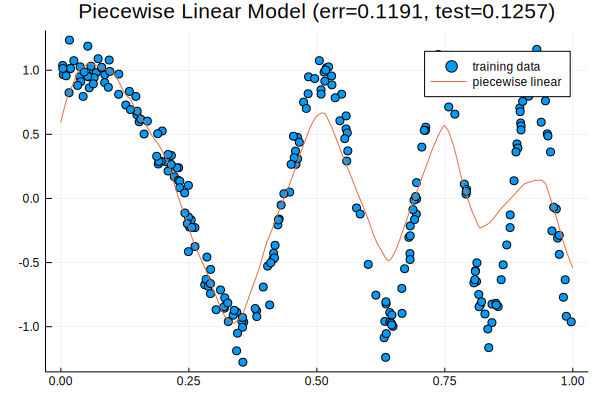

In [617]:
# let's train this with SGD

for k = 1:10000
    i = rand(1:n)
    (a, b, w) = (a, b, w) .- alpha .* grad(xs[i], ys[i], a, b, w);
end

err = mean((heval(xs[i],a,b,w)-ys[i])^2 for i = 1:n);
test_err = mean((heval(xs_test[i],a,b,w)-ys_test[i])^2 for i = 1:n);
us = collect(0.0:0.001:1.0);
scatter(xs, ys; label="training data", title="Piecewise Linear Model (err=$(round(err;digits=4)), test=$(round(test_err;digits=4)))");
plot!(us, [heval(u,a,b,w) for u in us]; label="piecewise linear")

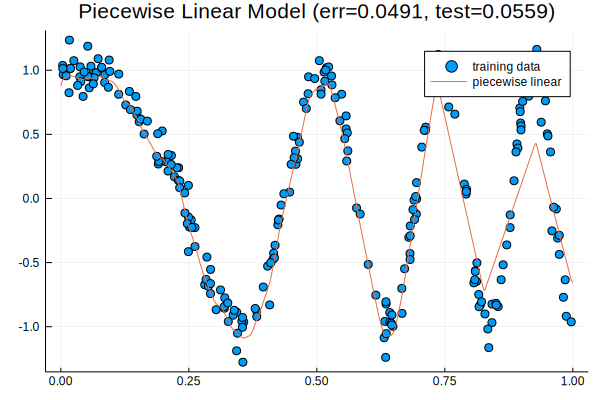

In [620]:
# train for many more iterations

for k = 1:100000
    i = rand(1:n)
    (a, b, w) = (a, b, w) .- alpha .* grad(xs[i], ys[i], a, b, w);
end

err = mean((heval(xs[i],a,b,w)-ys[i])^2 for i = 1:n);
test_err = mean((heval(xs_test[i],a,b,w)-ys_test[i])^2 for i = 1:n);
us = collect(0.0:0.001:1.0);
scatter(xs, ys; label="training data", title="Piecewise Linear Model (err=$(round(err;digits=4)), test=$(round(test_err;digits=4)))");
plot!(us, [heval(u,a,b,w) for u in us]; label="piecewise linear")

## The model did a pretty good job!

Okay but hold on...what does this have to do with deep neural networks? Well, it turns out the model we just trained **is** a deep neural network! It's a particular type of DNN that uses "ReLU activations."

* One way to think of a ReLU neural network is as a piecewise linear model.

## Deep Neural Networks more generally

In machine learning we usually want to make predictions not just from a single-dimensional input but from high-dimensional input feature vectors.

**How can we represent a piecewise linear function from a vector space to a vector space?**

ReLUs let us do this easily. For example, the function

$$f(x) = W \cdot \operatorname{ReLU}(Ax + b)$$

where the ReLU function is now taken elementwise on the vector $Ax + b$, is piecewise linear.